In [10]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [24]:
#tensorboard
import os

LOG_DIR = os.path.join(os.path.dirname(__file__), 'log')

if os.path.exists(LOG_DIR) is False:
    os.mkdir(LOG_DIR)

NameError: name '_file_' is not defined

In [2]:
np.random.seed(0)
tf.set_random_seed(1234)

def sin(x, T = 100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T = 100, ampl = 0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low = -1.0, high = 1.0, size = len(x))
    return sin(x) + noise

In [3]:
T = 100
f = toy_problem(T)

#split data
length_of_sequences = 2 * T
maxlen = 25

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [4]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

#split data
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

In [5]:
def inference(x, n_batch, maxlen = None, n_hidden = None, n_out = None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev = 0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype = tf.float32)
        return tf.Variable(initial)
        
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [6]:
class EarlyStopping():
    def __init__(self, patience = 0, verbose = 0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss
            
        return False

In [8]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

x = tf.placeholder(tf.float32, shape = [None, maxlen, n_in])
t  = tf.placeholder(tf.float32, shape = [None, n_out])
n_batch = tf.placeholder(tf.int32, shape = [])

y = inference(x, n_batch, maxlen = maxlen, n_hidden = n_hidden, n_out = n_out)
loss = loss(y, t)
train_step = training(loss)

early_stopping = EarlyStopping(patience=10, verbose=1)
history = {
    'val_loss': []
}

In [11]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
tf.summary.FileWriter(LOG_DIR, sess.graph) #tensorboard
sess.run(init)

n_batches = N_train // batch_size

for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict = {
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
        
    val_loss = loss.eval(session = sess, feed_dict = {
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' valodation loss:', val_loss)
    
    if early_stopping.validate(val_loss):
        break

epoch: 0  valodation loss: 0.2239888
epoch: 1  valodation loss: 0.10786649
epoch: 2  valodation loss: 0.056832127
epoch: 3  valodation loss: 0.038752005
epoch: 4  valodation loss: 0.033403065
epoch: 5  valodation loss: 0.028826578
epoch: 6  valodation loss: 0.02140338
epoch: 7  valodation loss: 0.0117071755
epoch: 8  valodation loss: 0.007710258
epoch: 9  valodation loss: 0.008689022
epoch: 10  valodation loss: 0.009044429
epoch: 11  valodation loss: 0.0068742237
epoch: 12  valodation loss: 0.008400779
epoch: 13  valodation loss: 0.009427298
epoch: 14  valodation loss: 0.0051897573
epoch: 15  valodation loss: 0.005854061
epoch: 16  valodation loss: 0.0069052917
epoch: 17  valodation loss: 0.005273175
epoch: 18  valodation loss: 0.00414886
epoch: 19  valodation loss: 0.0064274273
epoch: 20  valodation loss: 0.0034218396
epoch: 21  valodation loss: 0.003766617
epoch: 22  valodation loss: 0.003186089
epoch: 23  valodation loss: 0.003731235
epoch: 24  valodation loss: 0.0035326676
epoch: 2

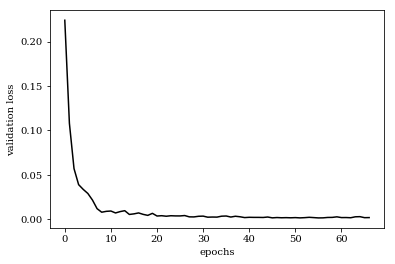

In [16]:
plt.rc('font', family = 'serif')
fig = plt.figure()

plt.plot(range(67), history['val_loss'], label = 'loss', color = 'black')

plt.xlabel('epochs')
plt.ylabel('validation loss')

plt.show()

In [20]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session = sess, feed_dict = {
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis = 0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis = 0)
    predicted.append(y_.reshape(-1))

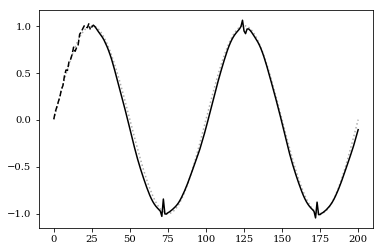

In [22]:
plt.rc('font', family = 'serif')
plt.figure()
plt.plot(toy_problem(T, ampl = 0), linestyle = 'dotted', color = '#aaaaaa')
plt.plot(original, linestyle = 'dashed', color = 'black')
plt.plot(predicted, color = 'black')
plt.show()